In [4]:
import torch 
from torch import nn
from torchvision import transforms, models 
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

In [5]:
DATA_PATH = Path('data')

In [6]:
class NST(nn.Module):
    def __init__(self, DATA_PATH):
        super().__init__()
        self.model = models.vgg19(pretrained=True).features
        for param in self.model.parameters():
            param.requires_grad = False
        self.layers = {'0' : 'conv1_1', '5' : 'conv2_1', '10': 'conv3_1',
                       '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}

        self.style_weights = {'conv1_1' : 1.0, 'conv2_1' : 0.8, 'conv3_1' : 0.4,
                         'conv4_1' : 0.2, 'conv5_1' : 0.1}

        self.DATA_PATH = DATA_PATH 

    def featureMap(self, x):
        features = {}
        x = x.unsqueeze(0)
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in self.layers:
                features[self.layers[name]] = x 

        return features
    
    @staticmethod
    def gramMatrix(imgfeature):
        _,d,h,w = imgfeature.size()
        imgfeature = imgfeature.view(d,h*w)
        gram_mat = torch.mm(imgfeature,imgfeature.t())
        
        return gram_mat

    def getContentStyle(self, content, style):  
        content = Image.open(self.DATA_PATH / 'content' / content).convert('RGB')
        style = Image.open(self.DATA_PATH / 'style' / style).convert('RGB')
        
        return content, style

    def __call__(self, content, style):
        style_features = self.featureMap(style)
        content_features = self.featureMap(content)
        style_grams = {layer: NST.gramMatrix(style_features[layer]) for layer in style_features}
        
        return content_features, style_grams 

In [7]:
tranform_dataset = transforms.Compose([
                            transforms.Resize(500),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [8]:
def convert2Image(image):
    x = image.clone().detach().numpy().squeeze()
    x = x.transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    return np.clip(x,0,1)

In [9]:
nst = NST(DATA_PATH)

In [10]:
content_filenames =  [filename.name for filename in (DATA_PATH / 'content').glob('*.jpg')]
style_filenames =  [filename.name for filename in (DATA_PATH / 'style').glob('*.jpg')]

In [11]:
style_filenames = [style_filenames[0]]

In [12]:
temp = [content_filenames[0],content_filenames[5]]
temp

['harrypotter1content.jpg', 'harrypotter2content.jpg']

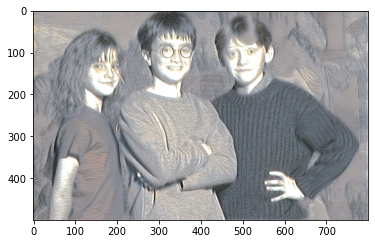

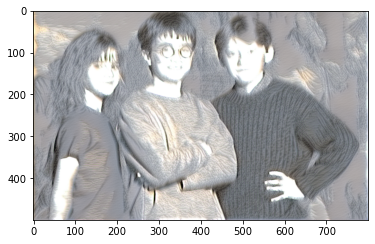

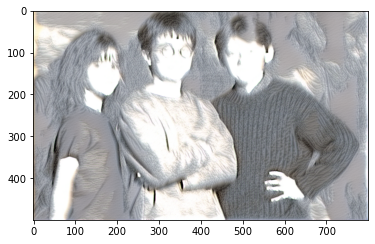

In [ ]:
content_weight = 100
style_weight = 1e8

print_after = 500
epochs = 2000

for content_file in temp:
    for  style_file in style_filenames:
        content, style = nst.getContentStyle(content_file, style_file)

        style = tranform_dataset(style)
        content = tranform_dataset(content)
        target = content.clone().requires_grad_(True)

        content_features, style_grams = nst(content, style)

        optimizer = torch.optim.Adam([target],lr=0.007)

        for index in range(epochs):
            target_features = nst.featureMap(target)
            content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)

            style_loss = 0
            for layer in nst.style_weights:
                style_gram = style_grams[layer]
                target_gram = target_features[layer]
                _,d,w,h = target_gram.shape
                target_gram = NST.gramMatrix(target_gram)

                style_loss += (nst.style_weights[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h

            total_loss = content_weight*content_loss + style_weight*style_loss 

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if index % print_after == 0 and index != 0:
                print("Epoch: {} Loss: {}".format(index, total_loss),end='\r', flush=True)
                plt.imshow(convert2Image(target), label="Epoch "+str(index))
                plt.show()
                plt.imsave('outputs/{}_{}_Epoch_{}.png'.format(content_file.split('.')[0], style_file.split('.')[0], index),convert2Image(target),format='png')